In [1]:
import os
import librosa
import pandas as pd
import numpy as np

from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image

import IPython
import IPython.display as ipd

In [2]:
# Data file path

ravdess_path = 'data'
ravdess_dir = os.listdir(ravdess_path)

# Loading in Audio Files

In [3]:
# Conversion into human understandable values 

emotions_convert = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

stetment_convert = {
    '01':'Kids are talking by the door',
    '02':'Dogs are sitting by the door'
}

In [4]:
gender_arr = []
path_arr = []
emotion_arr = []
statement_arr = []

for actor in ravdess_dir:
    
    if 'Actor' in actor: 
        actor_files = os.listdir(os.path.join(ravdess_path, actor))
        for audio_file in actor_files:                
            file_name = audio_file.split('.')[0]
            emotion_key = file_name.split('-')[2]
            gender_identifier = int(file_name.split('-')[6])
            statement_id = file_name.split('-')[4]
            path_arr.append(f"{ravdess_path}/{actor}/{audio_file}")

            if gender_identifier % 2 == 0:
                gender_arr.append("female")
            else:
                gender_arr.append("male")
            emotion_arr.append(emotions_convert[emotion_key])
            statement_arr.append(stetment_convert[statement_id])
             
df = pd.concat([
    pd.DataFrame(path_arr, columns = ['path']),
    pd.DataFrame(gender_arr, columns = ['gender']),
    pd.DataFrame(emotion_arr, columns = ['emotion']),
    pd.DataFrame(statement_arr, columns = ['statement'])
], axis = 1)

df

,path,gender,emotion,statement
0,data/Actor_16/03-01-05-01-02-01-16.wav,female,angry,Dogs are sitting by the door
1,data/Actor_16/03-01-06-01-02-02-16.wav,female,fearful,Dogs are sitting by the door
2,data/Actor_16/03-01-06-02-01-02-16.wav,female,fearful,Kids are talking by the door
3,data/Actor_16/03-01-05-02-01-01-16.wav,female,angry,Kids are talking by the door
4,data/Actor_16/03-01-07-01-01-01-16.wav,female,disgust,Kids are talking by the door
...,...,...,...,...
1435,data/Actor_08/03-01-03-02-02-02-08.wav,female,happy,Dogs are sitting by the door
1436,data/Actor_08/03-01-03-01-01-02-08.wav,female,happy,Kids are talking by the door
1437,data/Actor_08/03-01-02-02-01-01-08.wav,female,calm,Kids are talking by the door
1438,data/Actor_08/03-01-02-01-02-01-08.wav,female,calm,Dogs are sitting by the door


In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    #data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(new_data)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

# understaning sampling rate

In [6]:
import scipy
import scipy.fft
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [7]:
# Load the audio file
file = df.iloc[0]["path"]
audio, sr = librosa.load(file)

In [8]:
audio.shape[0], sr

(86081, 22050)

The audio file has a sampling rate of 22,050 Hertz. This means that each second of audio is represented by 22,050 individual samples. As a result, this 3.9 second audio file has 86,081 entries of data.

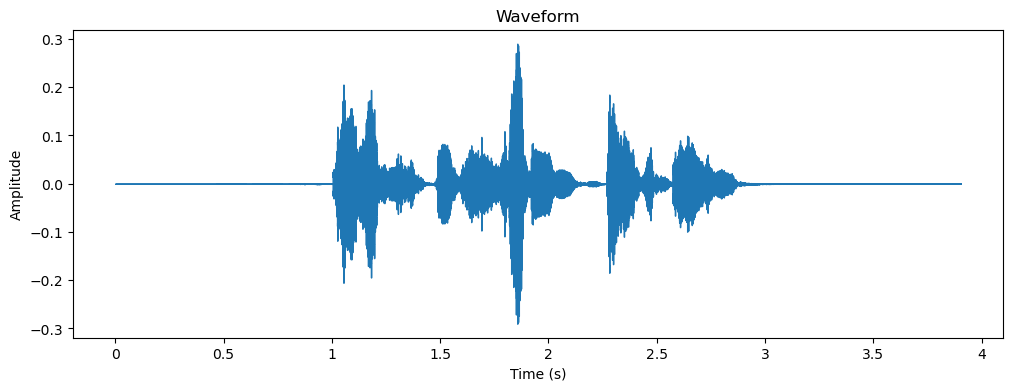

In [9]:
# Display the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [10]:
ipd.Audio(audio, rate=22050)

# Exploring feature extractions

In [11]:
f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
f0, voiced_flag, voiced_probs

(array([         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
        163.86452094, 162.92073075, 161.98237639, 204.08500573,
        263.14114678, 245.51937138, 244.10528385, 244.10528385,
                 nan,          nan, 311.12698372, 300.52885649,
        283.66146786, 283.66146786, 302.26980244, 339.28638159,
        347.21682483, 345.21700307,          nan,          nan,
                 nan,          nan,     

In [12]:
f0.shape

(169,)

In [13]:
voiced_flag.shape

(169,)

In [14]:
voiced_probs.shape

(169,)

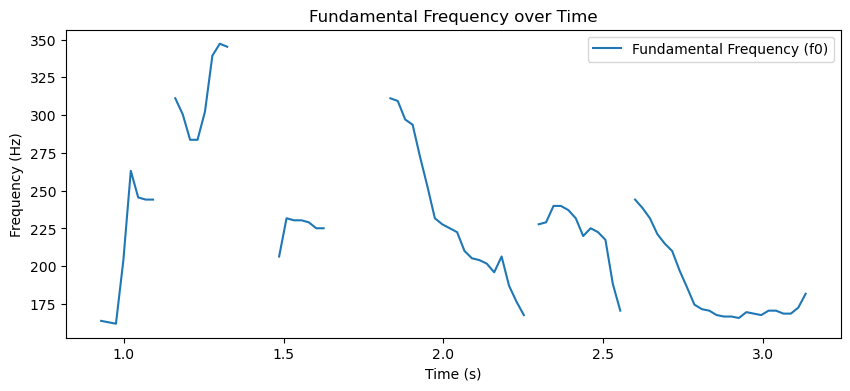

In [15]:
# Plotting the fundamental frequency over time
times = librosa.times_like(f0)
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label='Fundamental Frequency (f0)')
plt.legend()
plt.title('Fundamental Frequency over Time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [16]:
file = df.iloc[0]["path"]

In [17]:
from python_speech_features import mfcc
import streamlit as st


In [18]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file
file = df.iloc[0]["path"]
audio, sr = librosa.load(file)

# Extracting features

# mfcc
mfccs_psf = mfcc(audio,sr, numcep=20)

# mel-spectogram
sgram = librosa.stft(audio)
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
spectral_flatness = librosa.feature.spectral_flatness(y=audio)


In [45]:
mfccs_psf.shape

(389, 20)

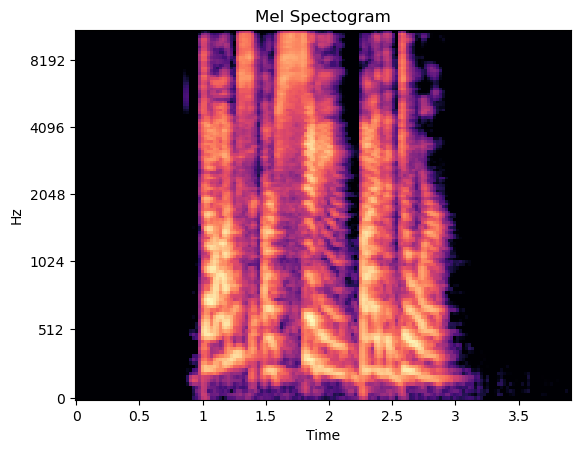

In [47]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.power_to_db(mel_sgram,ref=np.max),y_axis='mel',x_axis='time')
ax.set(title='Mel Spectogram')
plt.show()

In [20]:
melspectrogram = librosa.power_to_db(mel_sgram,ref=np.max)

In [21]:
melspectrogram.shape

(128, 169)

In [22]:
spectral_centroid.shape

(1, 169)

In [23]:
spectral_rolloff.shape

(1, 169)

In [24]:
spectral_bandwidth.shape

(1, 169)

In [25]:
spectral_contrast.shape

(7, 169)

In [26]:
spectral_flatness.shape

(1, 169)

In [27]:
file = df.iloc[0]["path"]

In [28]:
data, sample_rate = librosa.load(file, duration=2.5 ,offset=0.6)

In [29]:
data.shape

(55125,)

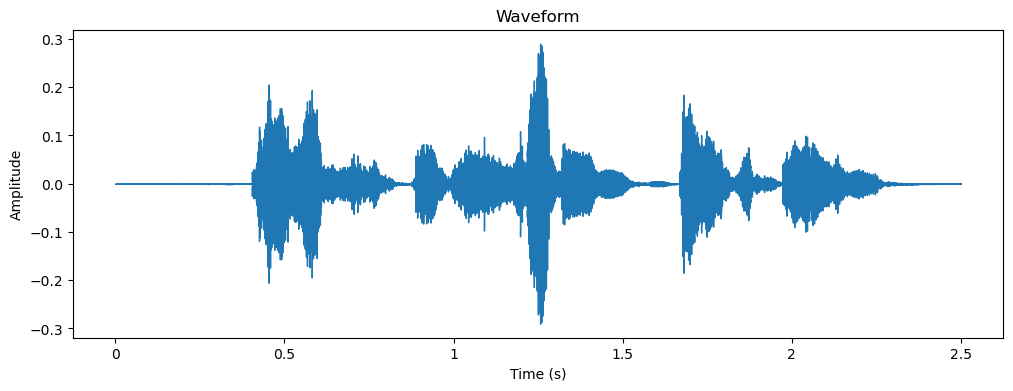

In [30]:
# Display the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [31]:
ipd.Audio(data, rate=sample_rate)

In [32]:
data

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0510735e-05,
       1.1858610e-04, 4.5811543e-05], dtype=float32)

In [33]:
result = np.array([])
zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
result=np.hstack((result, zcr)) # stacking horizontally

In [34]:
result

array([0.20454011])

In [35]:
# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

In [36]:
result

array([0.20454011, 0.51994687, 0.47024518, 0.49160317, 0.5605256 ,
       0.54873037, 0.61175412, 0.54726619, 0.53104836, 0.60742712,
       0.63430262, 0.62157589, 0.60325825])

In [37]:
# MFCC
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mfcc)) # stacking horizontally

In [38]:
result

array([ 2.04540111e-01,  5.19946873e-01,  4.70245183e-01,  4.91603166e-01,
        5.60525596e-01,  5.48730373e-01,  6.11754119e-01,  5.47266185e-01,
        5.31048357e-01,  6.07427120e-01,  6.34302616e-01,  6.21575892e-01,
        6.03258252e-01, -4.40286560e+02,  5.22992973e+01, -6.66586256e+00,
        4.27830410e+00, -1.58083143e+01, -9.86962986e+00, -1.39567957e+01,
       -1.83278370e+01, -1.85236874e+01, -2.28566599e+00, -1.15728579e+01,
       -9.50704765e+00, -5.05675125e+00, -8.62557507e+00, -9.51267624e+00,
       -8.53107929e+00, -3.47315478e+00, -1.07509212e+01, -9.17201424e+00,
       -3.56154275e+00])

In [39]:
# Root Mean Square Value
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
result = np.hstack((result, rms)) # stacking horizontally

In [40]:
result

array([ 2.04540111e-01,  5.19946873e-01,  4.70245183e-01,  4.91603166e-01,
        5.60525596e-01,  5.48730373e-01,  6.11754119e-01,  5.47266185e-01,
        5.31048357e-01,  6.07427120e-01,  6.34302616e-01,  6.21575892e-01,
        6.03258252e-01, -4.40286560e+02,  5.22992973e+01, -6.66586256e+00,
        4.27830410e+00, -1.58083143e+01, -9.86962986e+00, -1.39567957e+01,
       -1.83278370e+01, -1.85236874e+01, -2.28566599e+00, -1.15728579e+01,
       -9.50704765e+00, -5.05675125e+00, -8.62557507e+00, -9.51267624e+00,
       -8.53107929e+00, -3.47315478e+00, -1.07509212e+01, -9.17201424e+00,
       -3.56154275e+00,  1.87931657e-02])

In [41]:
librosa.feature.melspectrogram(y=data, sr=sample_rate).T.shape

(108, 128)

In [42]:
# MelSpectogram
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
# result = np.hstack((result, mel)) # stacking horizontally
mel.shape

(128,)

In [43]:
result = np.array([])
zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
result=np.hstack((result, zcr)) # stacking horizontally

# Chroma_stft
stft = np.abs(librosa.stft(data))
chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
result = np.hstack((result, chroma_stft)) # stacking horizontally

# MFCC
mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mfcc)) # stacking horizontally

# Root Mean Square Value
rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
result = np.hstack((result, rms)) # stacking horizontally

# MelSpectogram
mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
result = np.hstack((result, mel)) # stacking horizontally